In [91]:
import jax.numpy as jnp
import jax
import matplotlib.pyplot as plt
import jax.scipy as jsp 
import random
import os
import torch
plt.rc("figure", figsize=[6,6], dpi=150, facecolor='w')
import numpy as np
def seed_torch(seed=42):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    return np.random.default_rng(seed)
rng = seed_torch()

In [22]:
@jax.vmap
def TT(s):
    theta = jnp.arctan(s[1]/s[0])
    r = ((s[0]**2 + s[1]**2)**.5)/2
    T = jnp.array([[jnp.cos(theta), jnp.sin(theta)],[-jnp.sin(theta), jnp.cos(theta)]])@jnp.array([[1/r,0],[0,1]])
    return T@T.T

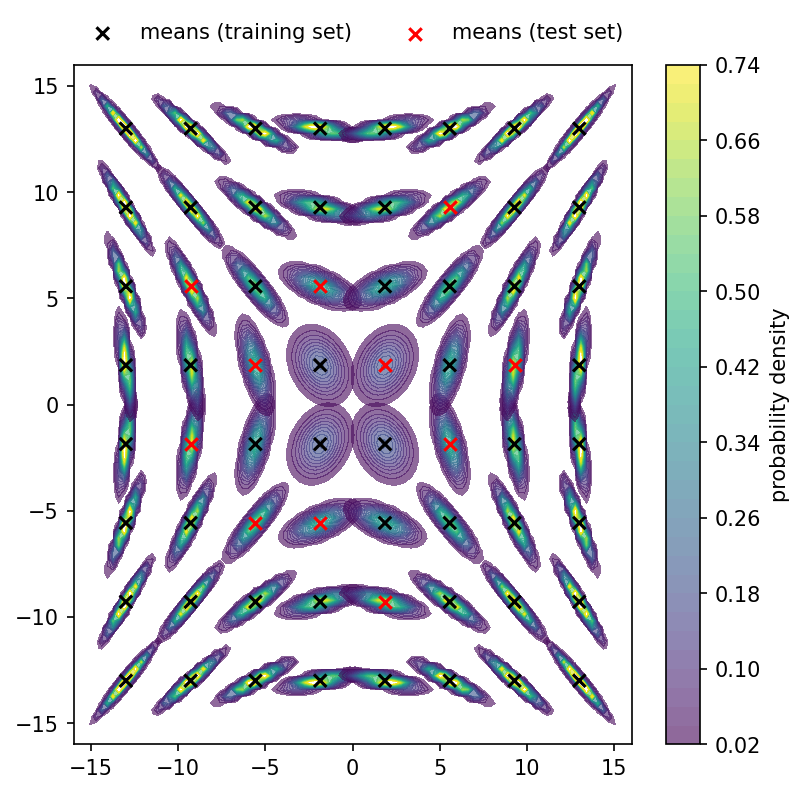

In [114]:

def xy_pairs(nx, ny, span):
    size = nx, ny
    x_grid = jnp.linspace(-span, span, nx)
    y_grid = jnp.linspace(-span, span, ny)
    xx, yy = jnp.meshgrid(x_grid, y_grid)
    return jnp.hstack((xx.reshape(-1,1), yy.reshape(-1,1))), size, xx, yy

val = 16
xy_pairs_eval, grid_size, xx, yy = xy_pairs(100,100, val)
num_means = 8
means, g, xx2, yy2 = xy_pairs(num_means,num_means, 13)
covs = TT(means)

def gaussian_2d_pdf(eval_points, mean, cov):
    return jsp.stats.multivariate_normal.pdf(eval_points, mean=mean, cov=cov)

vmapped_pdf = jax.vmap(gaussian_2d_pdf, in_axes=(None, 0, 0))

# covs = jnp.array([[[1, 0],[3,3]] for _ in means])
pdfs = vmapped_pdf(xy_pairs_eval, means, covs).reshape(len(means), *grid_size) 

fig, ax = plt.subplots()

step = 0.02
m = jnp.amax(pdfs[int(len(pdfs) / 2 - num_means/4)])
levels = jnp.arange(0.0, m, step) + step
for i,pdf in enumerate(pdfs):
    a = ax.contourf(xx, yy, pdf,  alpha=0.6, cmap='viridis',levels=levels)

inner_means = means.reshape(num_means, num_means, 2)[1:-1, 1:-1, :].reshape(-1, 2)
# idxs = rng.choice(len(inner_means), size=int(len(inner_means)/3), replace=False)
test = [[-5.5714287757873535, 1.8571434020996094],
 [1.8571434020996094, -9.285714149475098],
 [-1.8571422100067139, -5.5714287757873535],
 [-1.8571422100067139, 5.57142972946167],
 [1.8571434020996094, 1.8571434020996094],
 [5.57142972946167, -1.8571422100067139],
 [-5.5714287757873535, -5.5714287757873535],
 [-9.285714149475098, 5.57142972946167],
 [5.57142972946167, 9.285715103149414],
 [9.285715103149414, 1.8571434020996094],
 [-9.285714149475098, -1.8571422100067139]]

ax.scatter(xx2, yy2, marker='x', c=['None' if x in test else 'k' for x in means.tolist()], label ="means (training set)")
ax.scatter(np.array(test)[:,0], np.array(test)[:,1], marker='x', c='r', label ="means (test set)")

plt.colorbar(a, ax=ax, label="probability density")
ax.legend(bbox_to_anchor=(0,1.02,1,0.2), loc="lower left",
                mode="expand", borderaxespad=0, ncol=2, frameon=False)
# ax.legend(loc="upper center", fancybox=True,);

In [118]:
mask

[False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 True,
 False,
 False,
 False,
 False,
 False,
 True,
 True,
 False,
 False,
 False,
 False,
 False,
 True,
 False,
 False,
 False,
 True,
 False,
 False,
 False,
 False,
 True,
 False,
 True,
 False,
 True,
 False,
 False,
 True,
 False,
 True,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 True,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False]

In [127]:
from jax.random import multivariate_normal, PRNGKey

mask = jnp.array([x not in test for x in means.tolist()])

@jax.vmap
def samples(mean, cov):
    return multivariate_normal(PRNGKey(0), mean, cov, shape=(10000,))

train_samples = samples(means[mask], covs[mask])
assert train_samples.shape[0] == len(means) - len(test)

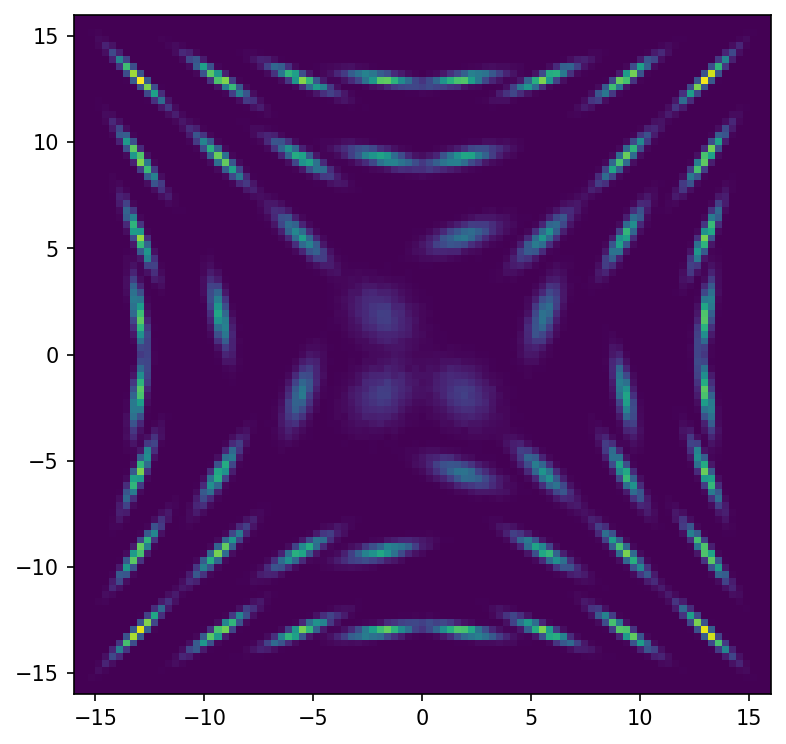

In [129]:
fig, ax = plt.subplots()

bins = np.linspace(-val, val, 100), np.linspace(-val, val, 100)


def plot(ax, s, i):
    x, y = s[:,0], s[:,1]
    ax.hist2d(x,y, density=True, bins=bins)
    ax.set_xlim((-val,val))
    ax.set_ylim((-val,val))

data = jnp.concatenate(train_samples)
plot(ax, data, 0)
# ax.scatter(xx2, yy2, marker='x', c='r', label ="distribution means")

In [133]:
from torch import nn
from torch import optim

from nflows.flows.base import Flow
from nflows.distributions.normal import ConditionalDiagonalNormal
from nflows.transforms.base import CompositeTransform
from nflows.transforms.autoregressive import MaskedAffineAutoregressiveTransform
from nflows.transforms.permutations import ReversePermutation



num_layers=6
hidden_features=4
optimiser=optim.Adam
optimiser_pars=dict(lr=1e-3)

base_dist = ConditionalDiagonalNormal(shape=[2], context_encoder=nn.Linear(2, 4))

transforms = []
for _ in range(num_layers):
    transforms.append(ReversePermutation(features=2))
    transforms.append(
        MaskedAffineAutoregressiveTransform(
            features=2, hidden_features=hidden_features, context_features=2
        )
    )
transform = CompositeTransform(transforms)

flow = Flow(transform, base_dist)
opt = optimiser(flow.parameters(), **optimiser_pars)